# Trabaho 1 - Machine Learning 1
#### Autores: 
Roberto Coutinho  
Thais Galho

Atividade:  

Agrupe os dados do censo americano de 2005 com o K-means e algum algoritmo hierarquico  
Não considerar a classe do conjunto de dados  
Somente um conjunto de dados  
Dados devem ser pré-processados  
Usar vários números de grupos (ex: 2 a 20)  
Medir a qualidade dos grupos com a silhueta (podem usar outros também)  
Qual é o melhor número de grupos? Qual é o melhor algoritmo? Motivos?  
Entregar via BB o código python ou jupyter e o passo a passo realizado (ex, motivos do pre-processamento etc.) em um zip.

### Imports

In [1]:
import numpy as np
import pandas as pd

from IPython.display import display
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabaz_score
from sklearn.metrics import confusion_matrix



Read the dataset and show

In [76]:
columns= ["age", 
        "workclass",
        "fnlwgt",
        "education",
        "education-num",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "capital-gain",
        "capital-loss",
        "hours-per-week",
        "native-country",
        "gain"]

censo = pd.read_csv('censo/adult.data', 
                    nrows=None, 
                    header=None,
                    index_col=None)

censo.columns = columns
      
censo.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,gain
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Remove the class labels

In [77]:
#Nao considerar a classe do conjunto de dados - coluna 14 representa a classe dos dados deste dataset
censo.drop(columns=["gain"] ,inplace=True)
censo.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Filter the only the columns to test

In [85]:
columns_to_filter = ['age', 'capital-gain']

df = censo.loc[:, columns_to_filter]

df.head()

,age,capital-gain
0,39,2174
1,50,0
2,38,0
3,53,0
4,28,0


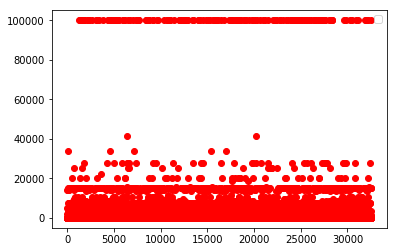

In [86]:
plt.figure(); 
plt.plot(df, 'ro'); 
plt.legend()

### Pré-processamento

### Execução 

In [33]:
scores = pd.DataFrame(columns=["n_clusters", 
                               "silhuete metric",
                               "calinski metric", 
                               "method",])

num_of_max_clusters = 5  # Number of clusters

print "Number of max clusters to validate : "+str(num_of_max_clusters)
print
print '##########################################################'
print

for i in range(num_of_max_clusters):
    
    i = i + 2 #Does not make sense do one cluster! Start with two.
    
    ##########################################################
    # Run kmeans
    ##########################################################    
    
    kmeans = KMeans(n_clusters=i, 
                    init='k-means++', 
                    n_init=10, 
                    max_iter=300)
    
    kmeans_clust = kmeans.fit(df)
    
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_    
    
    #Calculate the scores
    score_silhuete = silhouette_score(df,labels)
    score_ca = calinski_harabaz_score(df,labels)   
    
    #Add to score dataframe
    scores.loc[len(scores)] = [i, score_silhuete, score_ca, 'kmeans']
    
    ##########################################################
    # Run linkage
    ##########################################################
    
    link = linkage(df, 'single')
    
    clusters = fcluster(link, 
                        i, 
                        criterion='maxclust')
    
    #Calculate the scores
    score_silhuete_link = silhouette_score(df,clusters)
    score_ca_link = calinski_harabaz_score(df,clusters)    
    
    #Add to score dataframe
    scores.loc[len(scores)] = [i, score_silhuete_link, score_ca_link, 'linkage']
    
    #Calculate the confusion matrix : Predictions X ground truth
    conf_matrix = confusion_matrix(df.astype(int)['class'], labels)
    
    
   
    # Print results
    print 'Testing with '+str(i) +' clusters '
    print
    print 'Metrics'
    print scores.sort_values(['silhuete metric', 'calinski metric'], ascending=[False, False])
    print
    print 'Centroids'
    print centroids
    print
    print 'Labels'
    print labels
    print 
    print 'Confusion Matrix: Predicted X Ground Truth'
    print conf_matrix
    print
    print '--------------------------------'
    print 
    
    
    
    #print link
    #print '--------------------------------'




Number of max clusters to validate : 5

##########################################################



ValueError: could not convert string to float: United-States

In [4]:
print scores.head(10)

  n_clusters  silhuete metric  calinski metric   method
0          2         0.679803       497.157354   kmeans
1          2         0.682226       493.881371  linkage
2          3         0.581694       583.819609   kmeans
3          3         0.578011       568.547745  linkage
4          4         0.538462       519.279276   kmeans
5          4         0.519940       398.328841  linkage
6          5         0.513435       525.137745   kmeans
7          5         0.472410       323.251448  linkage
8          6         0.394483       495.493621   kmeans
9          6         0.446898       295.455704  linkage


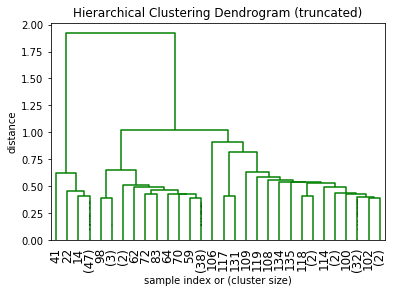

In [5]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

max_d = 5  # max_d as in max_distance

fancy_dendrogram(
    link,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

In [10]:
print df.astype(int)['class']

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
      ..
120    2
121    2
122    2
123    2
124    2
125    2
126    2
127    2
128    2
129    2
130    2
131    2
132    2
133    2
134    2
135    2
136    2
137    2
138    2
139    2
140    2
141    2
142    2
143    2
144    2
145    2
146    2
147    2
148    2
149    2
Name: class, Length: 150, dtype: int64


array([[ 0, 27,  0,  0,  0, 23],
       [ 0,  0, 23, 27,  0,  0],
       [37,  0,  1,  0, 12,  0],
       [ 0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0]])